In [1]:
from simulator.rl import RL, ActionSpace
from simulator.rl_wrapper import DecentralizedAggregatedSim
from simulator.simulator import Simulator
from simulator.fast_simulator import FastSimulator
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle as pkl
from simulator.constants import *
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [2]:
def plot_durations(rl_rsts, show_result=False):
    plt.figure(1)
    
    #durations_t = torch.tensor(episodes, dtype=torch.float)
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cummulative Reward', fontsize=14)
    plt.plot(rl_rsts)
    #plt.plot(fixed_rsts)
    plt.legend(["Score", "Comfort score", "Energy score"])
    #plt.ylim((0, 18))

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [3]:
from concurrent.futures import ProcessPoolExecutor

# Define the function to process each loop iteration
def process_loop_iteration(action, state, next_state, next_reward, model):
    next_state = model.step(action, state, next_state, next_reward)
    return next_state

In [4]:
def save(rl_models, rl_rsts, path):
    with open(f"{path}_model.pkl", "wb") as f:
        pkl.dump(rl_models, f)
    with open(f"{path}_convergence_plot.pkl", "wb") as f:
        pkl.dump(rl_rsts, f)

def train_rl(device, rl_models, action_space, interval, suffix, alpha, beta, path):
    rl_rsts = []
    # 500 days
    print("Training...")
    for i_episode in range(400):
        daily_score = []
        daily_comfort_score = []
        daily_energy_score = []
        # reset simulator
        sim = DecentralizedAggregatedSim(FastSimulator(interval=interval, suffix=suffix), alpha=alpha, beta=beta)
        # initialize simulator
        sim.step()
        store_names, state_mat = sim.get_states()
        states = []
        for state in state_mat:
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            states.append(state)
        
        #print(f"###day {i_episode}:###")
        # simulation for 1 day
        for i in range(19):
            #print(f"   time interval {i}:")
            # time=t: state, reward
            actions_tensor = []
            actions_list = []
            for state, model in zip(states, rl_models):
                action = model.select_action(state)
                rl_temp = action_space.convert(action.item())
                actions_list.append(rl_temp)
                actions_tensor.append(action)
            sim.apply_action(actions_list)
            #print("   action list:", actions_list)
            sim.step()
            store_names, next_state_mat = sim.get_states()
            next_rewards = sim.get_rewards()
            
            next_states = []
            for action, state, next_state, next_reward, model in zip(actions_tensor, states, next_state_mat, next_rewards, rl_models):
                next_state = model.step(action, state, next_state, next_reward)
                next_states.append(next_state)
            states = next_states

            #with ProcessPoolExecutor() as executor:
            #    next_states = list(executor.map(process_loop_iteration, actions_tensor, states, next_state_mat, next_rewards, rl_models))
            #states = next_states
            score, comfort_score, energy_score = sim.get_score()
            daily_score.append(score)
            daily_comfort_score.append(comfort_score)
            daily_energy_score.append(energy_score)

        #print(daily_cummulative_rwd, sum(daily_cummulative_rwd))
        rl_rsts.append([sum(daily_score), sum(daily_comfort_score), sum(daily_energy_score)])
        if i_episode % 50 == 0:
            plot_durations(rl_rsts)

    print('Complete')
    plot_durations(rl_rsts, show_result=True)
    plt.ioff()
    plt.show()

    save(rl_models, rl_rsts, path=path)
    return rl_models, rl_rsts

In [5]:
def run(alpha, beta, path, suffix=""):
    # if GPU is to be used
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device('cpu')
    interval = 30
    sim = DecentralizedAggregatedSim(FastSimulator(interval=interval, suffix=suffix), alpha=alpha, beta=beta)
    print(sim)
    sim.step()
    action_space = ActionSpace()
    # Get number of actions from gym action space
    n_actions = action_space.n
    # Get the number of state observations
    store_names, state_mat = sim.get_states()
    n_observations = state_mat.shape[1]

    rl_models = []
    for row in state_mat:
        rl_model = RL(n_observations, 
                    n_actions, 
                    action_space, 
                    model_complexity=128, 
                    lr_=5e-4, 
                    batch_size_=32)
        rl_models.append(rl_model)

    return train_rl(device, 
                    rl_models, 
                    action_space, 
                    interval=interval, 
                    suffix=suffix, 
                    alpha=alpha, 
                    beta=beta, 
                    path=path)

Complete


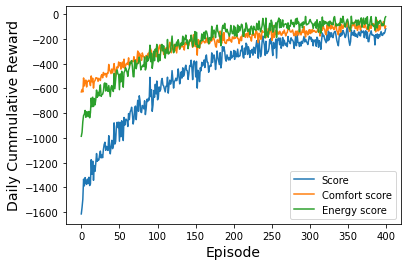

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

([<simulator.rl.RL at 0x2a711ae80>,
 [[-1614.4274125874124, -627.8217307692307, -986.6056818181818],
  [-1562.0227591232301, -607.5818500323205, -954.440909090909],
  [-1496.3223747086247, -628.0308974358976, -868.2914772727272],
  [-1333.608916524652, -514.9555074337427, -818.653409090909],
  [-1387.8590504911756, -579.4201300366299, -808.4389204545454],
  [-1320.6565477855477, -543.2088205128204, -777.4477272727272],
  [-1365.1002930525356, -532.1465998707174, -832.9536931818182],
  [-1375.6562272972126, -587.8636136608488, -787.7926136363637],
  [-1332.828114801865, -542.6014102564102, -790.2267045454544],
  [-1368.755139634875, -541.2346850894203, -827.5204545454545],
  [-1318.204108048814, -532.2370625942684, -785.9670454545454],
  [-1384.838334373959, -547.711913919414, -837.1264204545453],
  [-1371.7718144257701, -576.5030644257703, -795.26875],
  [-1175.895835813696, -498.5500971773324, -677.3457386363636],
  [-1293.6829990671094, -546.0094195216548, -747.6735795454547],
  [-11

In [6]:
path=f"saved_models/decentralized_control_ori"
run(alpha=ALPHA_, beta=BETA_, path=path)

Complete


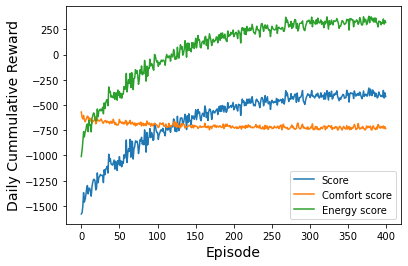

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

([<simulator.rl.RL at 0x2cc008b80>,
 [[-1579.5469811022313, -569.3827765567765, -1010.1642045454543],
  [-1569.0226806355408, -619.0587601809953, -949.9639204545456],
  [-1505.5700393479071, -637.8001529842707, -867.7698863636361],
  [-1368.8830394678848, -603.9969599224305, -764.8860795454544],
  [-1462.5636796536794, -644.9534523809523, -817.6102272727273],
  [-1435.0071777927956, -667.2958141564318, -767.7113636363636],
  [-1393.4247125619481, -646.9247125619478, -746.5],
  [-1327.7541047188108, -629.0666047188105, -698.6875000000001],
  [-1298.2832184482186, -610.0275366300366, -688.2556818181818],
  [-1380.751228979354, -616.473672161172, -764.2775568181818],
  [-1325.3124057021414, -670.7862693385047, -654.5261363636363],
  [-1325.4386521395272, -628.8809816849816, -696.5576704545454],
  [-1355.4116395687645, -657.3761282051281, -698.0355113636364],
  [-1403.6365205211453, -636.7510091575091, -766.8855113636364],
  [-1312.481103487199, -680.6876375781083, -631.7934659090909],
  [

In [7]:
path=f"saved_models/decentralized_control_alpha0"
run(alpha=0, beta=BETA_, path=path)

Complete


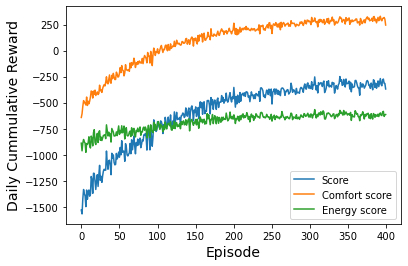

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

([<simulator.rl.RL at 0x2cc026fa0>,
 [[-1531.8625632284384, -642.3162564102563, -889.5463068181817],
  [-1568.6784603215413, -605.9355625942684, -962.7428977272729],
  [-1421.9491356143858, -534.7065219780219, -887.2426136363636],
  [-1334.28585477023, -480.3815934065934, -853.9042613636364],
  [-1376.4592806776552, -499.43115567765557, -877.0281249999999],
  [-1394.8398858127168, -506.4236926308985, -888.4161931818181],
  [-1498.9747088450763, -522.0184588450765, -976.9562500000002],
  [-1339.2064360884212, -446.2263224520577, -892.9801136363634],
  [-1428.0934009324008, -527.028628205128, -901.0647727272726],
  [-1369.4666512654012, -485.875173992674, -883.5914772727272],
  [-1338.6928469447219, -510.6942673992673, -827.9985795454545],
  [-1398.6540627705624, -484.7233809523809, -913.9306818181818],
  [-1379.8877558593367, -444.44144904115495, -935.4463068181818],
  [-1209.0846367627469, -388.0406026718379, -821.044034090909],
  [-1241.1418468198472, -395.71343772893766, -845.4284090

In [8]:
path=f"saved_models/decentralized_control_beta0"
run(alpha=ALPHA_, beta=0, path=path)